## Attempt for solving navier-stoke equation using PINNS

let us take the following PDE
$$
    \frac{\partial u}{\partial t}
    + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}
    =
    -\frac{1}{\rho} \frac{\partial p}{\partial x}
    + \nu \left(
    \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
    \right) \\[10pt]

  
    \frac{\partial v}{\partial t}
    + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}
    =
    -\frac{1}{\rho} \frac{\partial p}{\partial y}
    + \nu \left(
    \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}
    \right)
    \\[10pt]
   
    \left( \frac{\partial u}{\partial x} \right)^2 +
    2 \left( \frac{\partial u}{\partial y} \right)
    \left( \frac{\partial v}{\partial x} \right) +
    \left( \frac{\partial v}{\partial y} \right)^2
    = -\frac{1}{\rho}
    \left(
    \frac{\partial^2 p}{\partial x^2}
    + \frac{\partial^2 p}{\partial y^2}
    \right)
$$


The boundary conditions for the velocity are the following.
$$
u(t, x, l_y) = 1, \quad u(t, x, 0) = 0, \quad
u(t, 0, y) = 0, \quad u(t, l_x, y) = 0
$$
$$
v(t, x, l_y) = 0, \quad v(t, x, 0) = 0, \quad
v(t, 0, y) = 0, \quad v(t, l_x, y) = 0
$$

consider $l_x = l_y = 1$

The boundary condition for the pressure
$$
\frac{\partial p}{\partial x}\Big|_{x=0} = 0, \quad
\frac{\partial p}{\partial x}\Big|_{x=l_x} = 0, \quad
\frac{\partial p}{\partial y}\Big|_{y=0} = 0, \quad
p(t, x, l_y) = 0
$$

### PINNs attempt

We are going to train a neural network on the boundary conditions and the pde as constraints to find $u, v \& p$

The neural networkd is going to take 3 inputs (time, x, y) and produces 3 output (u, v, p), thus we need to initialize the inputs with the right dimensions

We are going to have $t \in [0,0.1]$ since we only want to see how system evolves in a small time step

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

In [2]:
x_0, x_f = 0.0, 1.0
y_0, y_f = 0.0, 1.0
t_0, t_f = 0.0 , 1.0

In [12]:
# set the device to be a GPU, if it is there
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Function to plot the output of the PINN

In [22]:
def plot_final_t_step(pinn, t=t_f):
  #create test input data
  x_test = torch.linspace(x_0, x_f, 100).to(device)
  y_test = torch.linspace(y_0, y_f , 100).to(device)
  test_data = torch.cartesian_prod(x_test, y_test, torch.tensor([t]).to(device))
  x_input_test, y_input_test, t_input_test = torch.split(test_data, 1, 1)

  #create a mesh
  x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="xy")
  x_grid, y_grid = x_grid.cpu().numpy(), y_grid.cpu().numpy()

  #get the output of the PINN
  u_test, v_test, p_test = pinn(x_input_test, y_input_test, t_input_test)
  u_test = u_test.squeeze().reshape(x_grid.shape).cpu().numpy()
  v_test = v_test.squeeze().reshape(x_grid.shape).cpu().numpy()
  p_test = p_test.squeeze().reshape(x_grid.shape).cpu().numpy()

  #plot the output
  figure = plt.figure(figsize=(5, 4), tight_layout=True, dpi=120)
  ax = figure.add_subplot(111)
  ax.set_xlim(x_0, x_f)
  ax.set_ylim(y_0, y_f)
  colormap = ax.pcolormesh(x_grid, y_grid, v_test.T, cmap="jet", shading="auto")
  figure.colorbar(colormap)
  plt.streamplot(x_grid, y_grid, u_test.T, v_test.T, color="black")
  plt.show()

In [15]:
def generate_data(x_num = 10, y_num=10, t_num=10):
    x_axis = torch.linspace(x_0, x_f,  x_num + 2)[1:-1] #exclude the boundary
    y_axis = torch.linspace(y_0, y_f, y_num + 2)[1: -1]
    t_axis = torch.linspace(t_0, t_f, t_num )
    data = torch.cartesian_prod(x_axis, y_axis, t_axis)
    return torch.split(data, 1, 1)

In [14]:
# the model
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN).to(device),
            activation()

        ])


        self.fch =nn.Sequential(*[ nn.Sequential(*[
            nn.Linear(N_HIDDEN, N_HIDDEN).to(device),
            activation()

        ]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN,N_OUTPUT).to(device)
        def weights_initialization(self):
                """"
                When we define all the modules such as the layers in '__init__()'
                method above, these are all stored in 'self.modules()'.
                We go through each module one by one. This is the entire network,
                basically.
                """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight,gain=1.0)
                nn.init.constant_(m.bias, 0)
    def forward(self, x, y, t):
        inputs = torch.cat((x, y, t), dim=1)
        inputs = self.fcs(inputs)
        inputs = self.fch(inputs)
        output = self.fce(inputs)

        # Split the output into u, v, and p
        u, v, p = torch.split(output, 1, dim=1)
        return u, v, p

In [13]:
x_physics , y_physics, t_physics = generate_data(15, 15, 15)
x_physics = x_physics.requires_grad_().to(device)
y_physics = y_physics.requires_grad_().to(device)
t_physics = t_physics.requires_grad_().to(device)
examples_num = len(x_physics)

#Boundary
y_up = torch.tensor( [y_f]*examples_num ).unsqueeze(-1).to(device)
y_down = torch.tensor( [y_0]*examples_num ).unsqueeze(-1).requires_grad_().to(device)
x_right = torch.tensor( [x_f]*examples_num ).unsqueeze(-1).requires_grad_().to(device)
x_left = torch.tensor( [x_0]*examples_num ).unsqueeze(-1).requires_grad_().to(device)

#Initial values
x_interior = torch.linspace(x_0, x_f, 17)[1:-1]
y_interior = torch.linspace(y_0, y_f, 17)[1:-1]
initial_points = torch.cartesian_prod(x_interior, y_interior, torch.tensor([t_0]))
x_interior, y_interior, t_initial = torch.split(initial_points.to(device), 1, 1)

In [18]:
def pde_loss(x, y, t, net, density=1.0, viscosity=0.1):
    u, v, p = net(x,y,t)
    u_x = torch.autograd.grad(u, x,torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),create_graph=True)[0]
    u_y = torch.autograd.grad(u, y,torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y,torch.ones_like(u_y), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x,torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x),create_graph=True)[0]
    v_y = torch.autograd.grad(v, y,torch.ones_like(v), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y,torch.ones_like(v_y), create_graph=True)[0]
    v_t = torch.autograd.grad(v,t,torch.ones_like(v), create_graph=True)[0]

    p_x = torch.autograd.grad(p,x,torch.ones_like(p), create_graph=True)[0]
    p_xx = torch.autograd.grad(p_x,x,torch.ones_like(p_x), create_graph=True)[0]
    p_y = torch.autograd.grad(p,y,torch.ones_like(p), create_graph=True)[0]
    p_yy = torch.autograd.grad(p_y,y,torch.ones_like(p_y), create_graph=True)[0]


    # Compute PDE losses
    loss1 = u_t + u * u_x + v * u_y + (1/density) * p_x - viscosity * (u_xx + u_yy)
    loss2 = v_t + u * v_x + v * v_y + (1/density) * p_y - viscosity * (v_xx + v_yy)
    # loss3 = (u_x)**2 + 2 * u_y * v_x + (v_y)**2 + (1/density) * (p_xx + p_yy)
    loss3 = u_x + v_y   #This one gives better result

    # Store losses in a dictionary
    losses = {
        'PDE1': loss1,
        'PDE2': loss2,
        'PDE3': loss3
    }
    loss_added = torch.mean(loss1**2) + torch.mean(loss2**2) + torch.mean(loss3**2)


    return losses, loss_added


### setting the boundary conditions
We are going to set the boundary conditions for neuman and dirchlit as the following

### building the NN

We are going to build NN with 3 inputs and 3 outpus as we mentioned before

In [20]:
pinn = FCN(3,3,30,5)
mse_cost_function = torch.nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-4)

u: 0.0009578942554071546, v: 0.00040644267573952675, p:0.00030336581403389573, pde:0.0013484181836247444


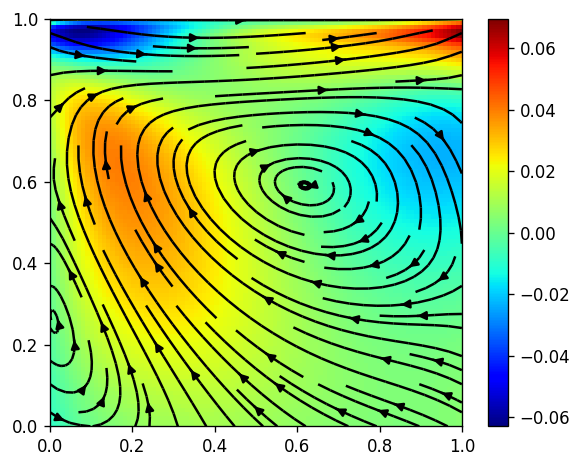

u: 0.0001511279260739684, v: 4.784220436704345e-05, p:5.0287082558497787e-05, pde:0.00023140227131079882


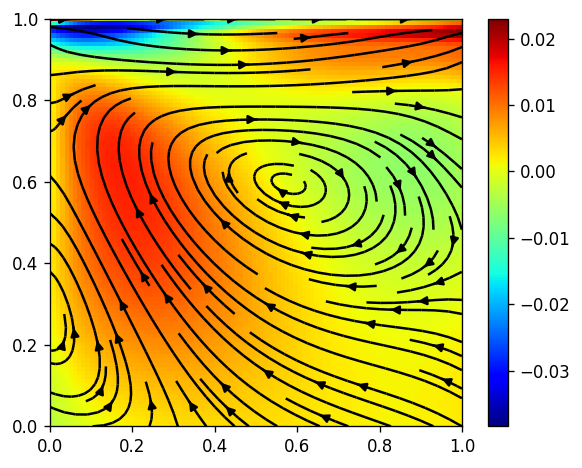

u: 6.041701271897182e-05, v: 1.8093258404405788e-05, p:2.1637839381583035e-05, pde:0.00011254534183535725


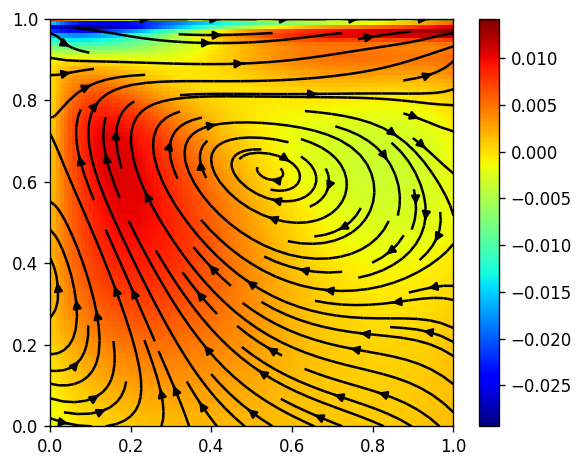

u: 3.327470039948821e-05, v: 9.995133041229565e-06, p:1.2190449524496216e-05, pde:5.249484092928469e-05


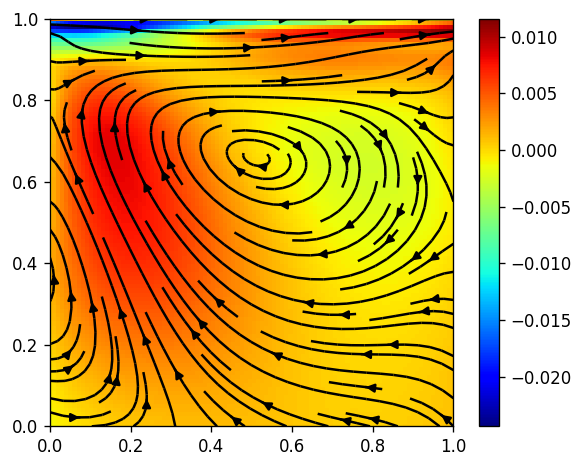

In [21]:
total_losses = []
iteration = []
boundary_loss = []
epochs = 40000

pinn.trian()
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()

    #Initial value loss
    u, v, p = pinn(x_interior, y_interior, t_initial)
    u_initial_loss = torch.mean( u**2 )
    v_initial_loss = torch.mean( v**2 )
    p_initial_loss = torch.mean( p**2 )
    initial_loss = u_initial_loss + v_initial_loss + p_initial_loss

    #Boundary loss, 1- top "y=1"
    u, v , p = pinn(x_physics, y_up, t_physics)
    u_top_loss = torch.mean( (u-1)**2 )
    v_top_loss = torch.mean( v**2 )
    p_top_loss = torch.mean( p**2 )
    top_loss = u_top_loss + v_top_loss + p_top_loss

    #Boundary loss, 2 - down "y=0"
    u, v , p = pinn(x_physics, y_down, t_physics)
    u_down_loss = torch.mean( u**2 )
    v_down_loss = torch.mean( v**2 )
    p_y = torch.autograd.grad(p, y_down, torch.ones_like(p), create_graph=True)[0]
    p_down_loss = torch.mean( p_y**2 )
    down_loss = u_down_loss + v_down_loss + p_down_loss

    # Boundary loss, 3 - left "x=0"
    u, v , p = pinn(x_left, y_physics, t_physics)
    u_left_loss = torch.mean( u**2 )
    v_left_loss = torch.mean( v**2 )
    p_x = torch.autograd.grad(p, x_left, torch.ones_like(p), create_graph=True)[0]
    p_left_loss = torch.mean( p_x**2 )
    left_loss = u_left_loss + v_left_loss + p_left_loss

    # Boundary loss, 4 - right "x=1"
    u, v , p = pinn(x_right, y_physics, t_physics)
    u_right_loss = torch.mean( u**2 )
    v_right_loss = torch.mean( v**2 )
    p_x = torch.autograd.grad(p, x_right, torch.ones_like(p), create_graph=True)[0]
    p_right_loss = torch.mean( p_x**2 )
    right_loss = u_right_loss + v_right_loss + p_right_loss

    #losses for each variable u, v, p
    u_loss = u_initial_loss + u_top_loss + u_left_loss + u_down_loss + u_right_loss
    v_loss = v_initial_loss + v_top_loss + v_left_loss + v_down_loss + v_right_loss
    p_loss = p_initial_loss + p_top_loss + p_left_loss + p_down_loss + p_right_loss

    # pde loss
    pde_losses, losses_added = pde_loss(x = x_physics, y = y_physics, t = t_physics, net = pinn  )
    # pde_loss0 = mse_cost_function(losses_added, torch.zeros((examples_num,1)))
    loss = losses_added +  u_loss + v_loss +  p_loss

    # back propagation
    loss.backward()
    optimizer.step()
    total_losses.append(loss.detach())
    # if epoch % 1000 == 0:
    #     total_losses.append(loss.detach())
    #     print(total_losses[-1])

    if epoch % 10000 == 0:
      pinn.eval()
      print(f"u: {u_loss.item()}, v: {v_loss.item()}, p:{p_loss.item()}, pde:{losses_added.item()}")
      with torch.inference_mode():
        plot_final_t_step(pinn)
      pinn.train()